In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.special import ndtri
from scipy.optimize import curve_fit
from scipy.stats import binom
sns.set(rc={'figure.figsize': (15, 6)})
%config InlineBackend.figure_format = 'retina'

## Psychometric function exercise - **Responsible: Mikkel**

In a 3-alternative classification task, the observer classifies speech sounds under varying sound intensities. The experiment consists of 30 experimental trials at each sound intensity. The sound intensities and the corresponding number of correct responses are shown in the table below.

In [ ]:
trials_n = 30
experiment = pd.DataFrame({
    'Stimulus intensity (dB)': [5,10,15,20,25,30],
    'Number of correct responses': [12,11,19,27,30,30]
})

# proportion of correct responses
experiment['P_c'] = experiment['Number of correct responses'] / trials_n
experiment

# proportion of correct responses (guess correction)
P_guess = 1/3
experiment['P_c_tilde'] = (experiment['P_c'] - P_guess) / (1 - P_guess)

experiment

,Stimulus intensity (dB),Number of correct responses,P_c,P_c_tilde
0,5,12,0.400000,0.10
1,10,11,0.366667,0.05
2,15,19,0.633333,0.45
3,20,27,0.900000,0.85
4,25,30,1.000000,1.00
5,30,30,1.000000,1.00


### Fit the high threshold model in Equation $1.12$ and the psychometric function in Equation $1.11$ to the data.

**Psychometric:**
$\Psi\left(I_s\right)=P\left(r=\text { yes } \mid I_s\right)=\Phi\left(\frac{I_s-c}{\sigma}\right)$ (1.11)

**High threshold:**
$P_c\left(I_s\right)=\tilde{P}_c\left(I_s\right)+\left(1-\tilde{P}_c\left(I_s\right)\right) P_{g u e s s}$ (1.12)

In [ ]:
# defining the two models

# psychometric function (without correction)
def phychometric(I_s, c, sigma):
    P_s = norm.cdf((I_s - c)/sigma)
    return P_s # P_s is considered P_yes as in perceived

# high treshold model i.e. extended psychometric with correction
def high_threshold(I_s, c, sigma, P_guess):
    P_c_tilde = phychometric(I_s, c, sigma)
    P_c = P_c_tilde + (1-P_c_tilde)*P_guess
    return P_c

# defining known variables
N = 30 * 6 # 30 trials for each of the 6 stimulus
N_s = 30
I_s = experiment['Stimulus intensity (dB)']
n_s = experiment['Number of correct responses']
P_s = experiment['P_c'] # proportion correct
P_s_tilde = experiment['P_c_tilde']
n = n_s.sum()

In [ ]:
# fit the models using curve fit
from scipy.optimize import curve_fit

# psychometric
par, mcov = curve_fit(phychometric, I_s, P_s, (0., 1.))
print(f"Psychometric: c_hat = {par[0]}, sigma_hat = {par[1]}")

# high treshold
par, mcov = curve_fit(high_threshold, I_s, P_s, (0., 1., 0.33))
print(f"High Threshold: c_hat = {par[0]}, sigma_hat = {par[1]}, P_guess = {par[2]}")

Psychometric: c_hat = 10.467195877742157, sigma_hat = 9.555030136016514
High Threshold: c_hat = 16.03544419737617, sigma_hat = 3.5844379353909215, P_guess = 0.37374436912957903


In [ ]:
# fit models using negative log-likelihood (as objective functions) and optimization routines
from scipy.optimize import minimize

# tried writing the negative log likelihood from scratch. Can't get it to work...
# -(np.log(np.arange(1, N_s + 1)).sum() - np.array([np.log(np.arange(1, s + 1)).sum() for s in n_s]) - np.log(N_s - n_s) + n_s * np.log(P_s) + (N_s - n_s) * np.log(1 - P_s)).sum()

# nll phychometric
def nll_phychometric(args):
    P_s = phychometric(I_s, *args)
    cost = binom.logpmf(k = n_s, n = N_s, p = P_s).sum()
    return -cost # minimize this!
res_s = minimize(fun = nll_phychometric, x0 = (10., 10.) )
print(f"Psychometric: c_hat = {res_s['x'][0]}, sigma_hat = {res_s['x'][1]}")

# nll high treshold
def nll_high_threshold(args):
    P_c = high_threshold(I_s, *args)
    cost = binom.logpmf(k = n_s, n = N_s, p = P_c).sum()
    return -cost
res_c = minimize(fun = nll_high_threshold, x0 = (5., 5., 0.33) )
print(f"High Treshold: c_hat = {res_c['x'][0]}, sigma_hat = {res_c['x'][1]}, P_guess = {res_c['x'][2]}")

Psychometric: c_hat = 10.131847938970719, sigma_hat = 8.190827074357555
High Treshold: c_hat = 16.154587139272397, sigma_hat = 3.489877317915898, P_guess = 0.3773354589158717


**Answer:** Parameters estimated using curve fit and cost function.

### Make one plot with the two psychometric functions with the data. Estimate which of the two psychometric functions fit the data better.

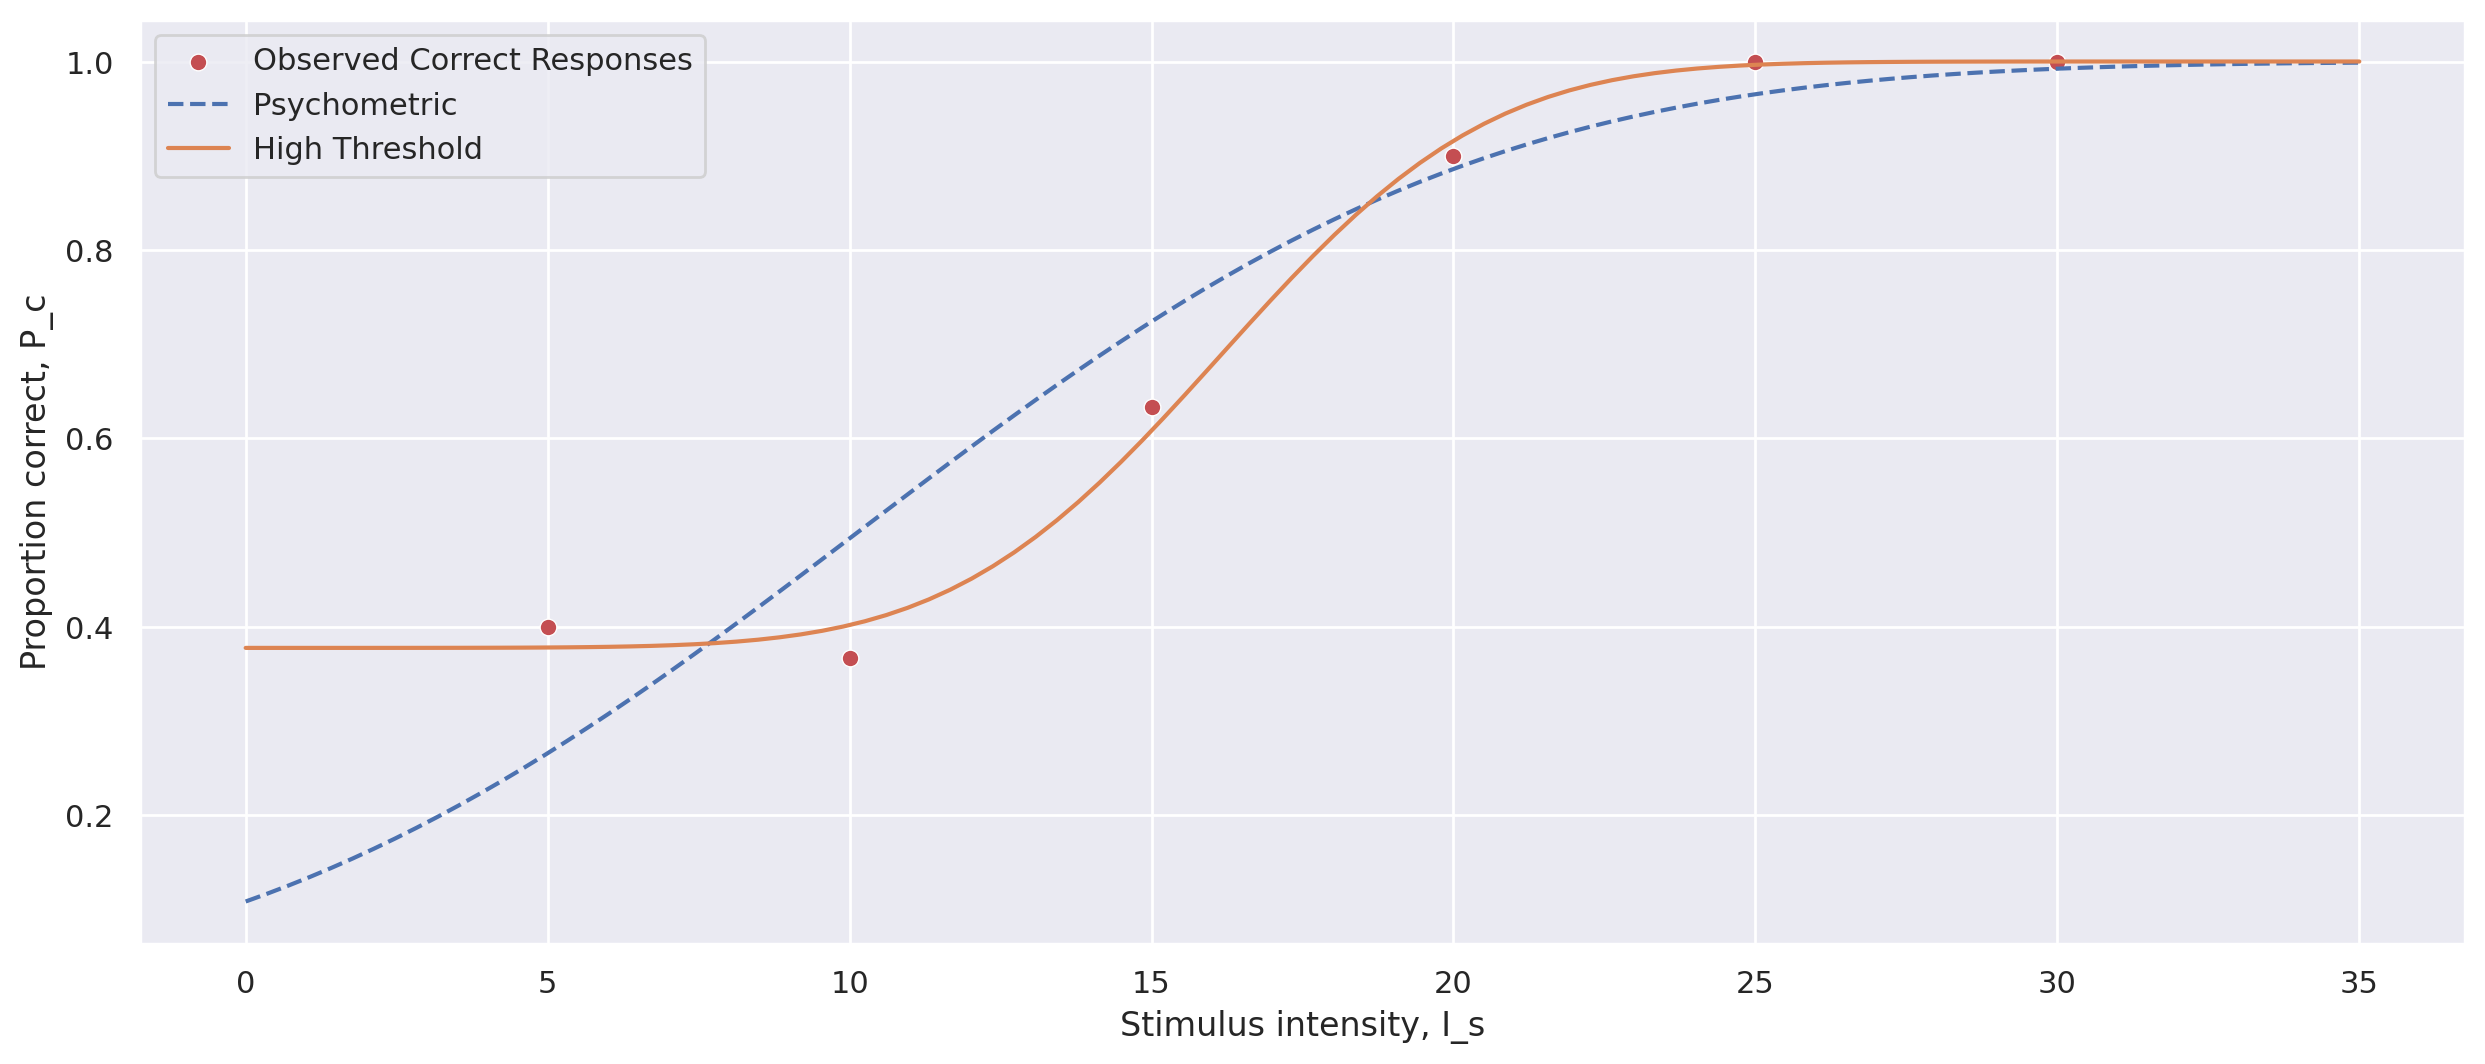

In [ ]:
fig, ax = plt.subplots()

# plot data points
sns.scatterplot(x = I_s, y = P_s, label='Observed Correct Responses', color='r')

# plot psychometric
x = np.linspace(0, 35, 100)
y = phychometric(x, res_s['x'][0], res_s['x'][1])
sns.lineplot(x = x, y = y, label='Psychometric', linestyle='--')

# plot high threshold
y = high_threshold(x, res_c['x'][0], res_c['x'][1], res_c['x'][2])
sns.lineplot(x = x, y = y, label='High Threshold')

plt.ylabel("Proportion correct, P_c")
plt.xlabel("Stimulus intensity, I_s")
plt.legend()
plt.show();

In [ ]:
# estimate errors for both functions. Which performs best?
from sklearn.metrics import mean_squared_error

# psychometric
mse1 = mean_squared_error(P_s, phychometric(P_s, res_s['x'][0], res_s['x'][1]))
print(f"Psychometric MSE: {mse1:3.2f}")

# high threshold
mse2 = mean_squared_error(P_s, high_threshold(P_s, res_c['x'][0], res_c['x'][1], res_c['x'][2]))
print(f"High Threshold MSE: {mse2:3.2f}")

Psychometric MSE: 0.42
High Threshold MSE: 0.19


**Answer:** High Threshold fits the data best by MSE metric.

### List the value of the negative log likelihood of the two models. Which is lower?

In [ ]:
# looking at the last nll result for each model
print(f"Psychometric NLL: {res_s['fun']:3.2f}")
print(f"High Threshold NLL: {res_c['fun']:3.2f}")

Psychometric NLL: 11.32
High Threshold NLL: 7.46


**Answer:** The High Threshold model has the lowest negative log likelihood.

### List the parameter values for each of the two models. Do the two models give similar estimates of the parameter values?

In [ ]:
print(f"Psychometric: c_hat = {res_s['x'][0]:3.2f}, sigma_hat = {res_s['x'][1]:3.2f}")
print(f"High Treshold: c_hat = {res_c['x'][0]:3.2f}, sigma_hat = {res_c['x'][1]:3.2f}, P_guess = {res_c['x'][2]:3.2f}")

Psychometric: c_hat = 10.13, sigma_hat = 8.19
High Treshold: c_hat = 16.15, sigma_hat = 3.49, P_guess = 0.38


**Answer:** ...
- TODO: why are the parameters this different?
- TODO: what does the c and sigma tell us about the two models?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7393f88e-6674-4a74-8a6c-ce9dc44581ca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>